In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load node embeddings

In [4]:
xcf_emb=pd.read_pickle('datasets/(07.10)xcf_tb_n2v_node.pkl')
ars_emb=pd.read_pickle('datasets/(07.10)ars_tb_n2v_node.pkl')
kb_emb=pd.read_pickle('datasets/(07.10)kb_tb_n2v_node.pkl')

In [5]:
print(xcf_emb.shape)
print(ars_emb.shape)
print(kb_emb.shape)

(130, 4)
(143, 4)
(155, 4)


In [6]:
xcf_emb.head()

,ingr,embeddings,comb_cate,node_type
0,water,"[-0.010832663, -0.25349423, 0.12803248, -0.082...",Additive/Spice,ingr
1,millet,"[-0.15548918, -0.24214248, 0.09402079, -0.1290...",Seed/Nut/Legume,ingr
2,jujube,"[0.1220731, -0.27520975, 0.024578419, 0.072487...",Fruit,ingr
3,walnut,"[-0.106272854, -0.21690252, 0.015327703, -0.07...",Seed/Nut/Legume,ingr
4,sesame,"[-0.050445683, 0.03135486, -0.094322495, -0.12...",Seed/Nut/Legume,ingr


In [7]:
# load ingredient datasets

In [6]:
xcf_ingr=pd.read_pickle('~/food_flavor_2022/datasets/(14.09)xcf_tb_flavordb.pkl')
ars_ingr=pd.read_pickle('~/food_flavor_2022/datasets/(23.09)ars_tb_flavordb.pkl')
kb_ingr=pd.read_pickle('~/food_flavor_2022/datasets/(07.09)kb_tb_flavordb.pkl')

In [7]:
print(xcf_ingr.shape)
print(ars_ingr.shape)
print(kb_ingr.shape)

(2366, 3)
(2133, 3)
(1864, 3)


In [10]:
# keep the app of the recipes

In [8]:
xcf_app=xcf_ingr[['recipe_id','class']]
ars_app=ars_ingr[['recipe_id','class']]
kb_app=kb_ingr[['recipe_id','class']]

In [9]:
xcf_ingr.drop('class',axis=1,inplace=True)
ars_ingr.drop('class',axis=1,inplace=True)
kb_ingr.drop('class',axis=1,inplace=True)

In [10]:
ars_ingr.head()

,recipe_id,flavordb_ingr
0,152,"[butter, buttermilk, cooking_oil, egg, flour, ..."
1,198,"[biscuit, butter, codfish, lemon, onion, parsl..."
2,313,"[apple, butter, capsicum, cheddar_cheese, egg,..."
3,382,"[beef, carrot, celery, garlic, kale, kidney_be..."
4,596,"[biscuit, chocolate, cream_cheese, egg, sugar,..."


In [11]:
xcf_ingredients=list(set(xcf_emb['ingr'].values.tolist()))
ars_ingredients=list(set(ars_emb['ingr'].values.tolist()))
kb_ingredients=list(set(kb_emb['ingr'].values.tolist()))

In [12]:
xcf_ingr_emb=dict(zip(xcf_emb['ingr'],xcf_emb['embeddings']))
ars_ingr_emb=dict(zip(ars_emb['ingr'],ars_emb['embeddings']))
kb_ingr_emb=dict(zip(kb_emb['ingr'],kb_emb['embeddings']))

In [13]:
def get_node2vec_features(ingredients,sentence,embedding_dict):
    featureVec=np.zeros(128,dtype='float32')
    
    nwords=0
    for word in sentence:
        if word in ingredients:
            featureVec=np.add(featureVec,embedding_dict[word])
            nwords+=1
        else:
            featureVec=featureVec
    if nwords > 0:
        featureVec=np.divide(featureVec,nwords)
    return featureVec

In [14]:
xcf_ingr['n2v_features']=list(map(lambda sentence:get_node2vec_features(xcf_ingredients,sentence,xcf_ingr_emb),xcf_ingr['flavordb_ingr']))

In [15]:
ars_ingr['n2v_features']=list(map(lambda sentence:get_node2vec_features(ars_ingredients,sentence,ars_ingr_emb),ars_ingr['flavordb_ingr']))

In [16]:
kb_ingr['n2v_features']=list(map(lambda sentence:get_node2vec_features(kb_ingredients,sentence,kb_ingr_emb),kb_ingr['flavordb_ingr']))

In [17]:
xcf_ingr.head()

,recipe_id,flavordb_ingr,n2v_features
0,100000175,"[rice, salt, cabbage, oats, pepper]","[0.12998615, 0.116523266, -0.12934923, -0.1582..."
1,100000387,"[salt, broccoli, cooking_oil, pork]","[0.045320638, 0.108172126, -0.038546618, -0.17..."
2,100000424,"[tomato, soybean_sauce, garlic, salt, cabbage,...","[0.0671796, 0.17074816, -0.070094116, -0.07578..."
3,100000444,"[shiitake, garlic, salt, cabbage, soybean_sauc...","[0.08900865, 0.0965947, -0.06276641, -0.123147..."
4,100000562,"[durian, water]","[-0.010832663, -0.25349423, 0.12803248, -0.082..."


In [18]:
# K-means

In [19]:
from sklearn.cluster import KMeans

In [23]:
def elbow_methond(embeddings):
    distortions=[]
    K=range(1,10)
    for k in K:
        kmeansModel=KMeans(n_clusters=k)
        kmeansModel.fit(embeddings)
        distortions.append(kmeansModel.inertia_)
    # return distortions
    plt.figure(figsize=(7,7))
    plt.plot(K,distortions,'bx-')
    plt.xlabel('X')
    plt.xlabel('distortions')
    plt.show()

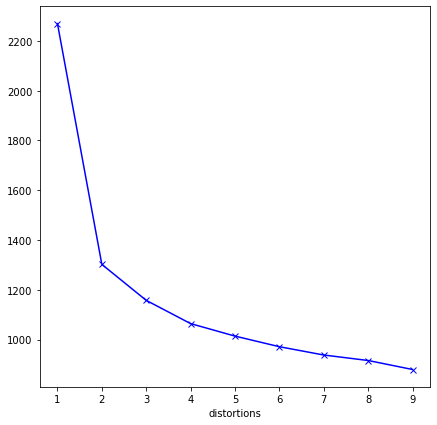

<Figure size 432x288 with 0 Axes>

In [27]:
elbow_methond(xcf_ingr['n2v_features'].values.tolist())
plt.savefig('graphs/pdf/xcf_n2v_cluster_elbow.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/xcf_n2v_cluster_elbow.png',dpi=300,bbox_inches='tight')

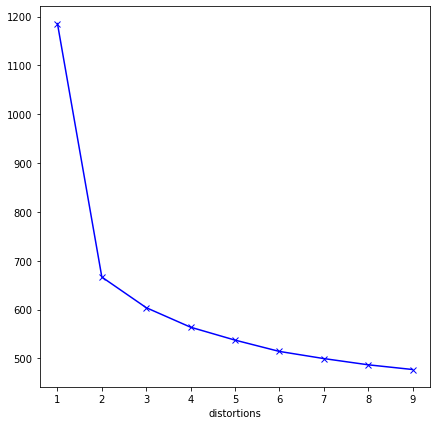

<Figure size 432x288 with 0 Axes>

In [28]:
elbow_methond(ars_ingr['n2v_features'].values.tolist())
plt.savefig('graphs/pdf/ars_n2v_cluster_elbow.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/ars_n2v_cluster_elbow.png',dpi=300,bbox_inches='tight')

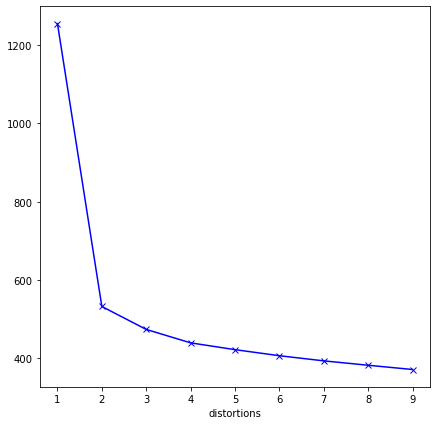

<Figure size 432x288 with 0 Axes>

In [29]:
elbow_methond(kb_ingr['n2v_features'].values.tolist())
plt.savefig('graphs/pdf/kb_n2v_cluster_elbow.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/kb_n2v_cluster_elbow.png',dpi=300,bbox_inches='tight')

In [30]:
kmeansmodels=KMeans(n_clusters=2,random_state=9527)
kmeansmodels.fit(xcf_ingr['n2v_features'].values.tolist())
xcf_ingr['cluster']=kmeansmodels.predict(xcf_ingr['n2v_features'].values.tolist())

In [31]:
kmeansmodels=KMeans(n_clusters=2,random_state=9527)
kmeansmodels.fit(ars_ingr['n2v_features'].values.tolist())
ars_ingr['cluster']=kmeansmodels.predict(ars_ingr['n2v_features'].values.tolist())

In [32]:
kmeansmodels=KMeans(n_clusters=2,random_state=9527)
kmeansmodels.fit(kb_ingr['n2v_features'].values.tolist())
kb_ingr['cluster']=kmeansmodels.predict(kb_ingr['n2v_features'].values.tolist())

In [33]:
xcf_ingr.tail()

,recipe_id,flavordb_ingr,n2v_features,cluster
2361,99004,"[flour, milk_powder, kidney_beans, cocoa_powde...","[0.039294135, -0.20061953, -0.099041894, -0.20...",1
2362,99622,[tomato],"[0.14829426, 0.18041599, -0.11437185, -0.12858...",0
2363,99634,"[flour, butter, green_tea, egg, sugar]","[0.1174195, -0.107033, -0.006702161, -0.195767...",1
2364,99672,[shrimp],"[0.0579015, 0.18281163, 0.0022510057, -0.02648...",0
2365,99673,"[vinegar, garlic, salt, welsh_onion, pepper, s...","[0.13126345, 0.121772766, -0.10714755, -0.0962...",0


In [34]:
ars_ingr.head(20)

,recipe_id,flavordb_ingr,n2v_features,cluster
0,152,"[butter, buttermilk, cooking_oil, egg, flour, ...","[0.11621567, 0.08857763, -0.054273322, -0.1196...",1
1,198,"[biscuit, butter, codfish, lemon, onion, parsl...","[0.13179116, -0.0033423267, -0.15062986, -0.06...",0
2,313,"[apple, butter, capsicum, cheddar_cheese, egg,...","[0.07221363, 0.11513465, -0.12977144, -0.13726...",1
3,382,"[beef, carrot, celery, garlic, kale, kidney_be...","[0.08575482, 0.17138842, -0.13551678, -0.14606...",0
4,596,"[biscuit, chocolate, cream_cheese, egg, sugar,...","[0.18244456, -0.055677306, -0.0503502, -0.1237...",1
5,684,"[butter, capers, chicken, flour, lemon, parsle...","[0.092153564, 0.084291, -0.14789513, -0.097953...",0
6,798,"[beef, bread, celery, cheddar_cheese, clove, c...","[0.100173794, 0.12647894, -0.13793921, -0.1226...",0
7,991,"[butter, capsicum, cardamom, cinnamon, clove, ...","[0.03448935, 0.13718326, -0.12482436, -0.09747...",0
8,1122,"[butter, buttermilk, egg, flour, lemon, lemon_...","[0.11868665, 0.07084132, -0.0863833, -0.114490...",1
9,1825,"[beef, biscuit, capsicum, celery, clove, egg, ...","[0.07514115, 0.12038509, -0.12448086, -0.12509...",0


In [35]:
kb_ingr.head(20)

,recipe_id,flavordb_ingr,n2v_features,cluster
0,731,"[asparagus, butter, capsicum, chive, cooking_o...","[0.14468089, 0.10974136, -0.029073082, -0.0439...",0
1,964,"[cocoa_powder, cream, egg, red_wine, sugar]","[0.09935913, 0.010888529, 0.08955122, -0.18694...",1
2,1182,"[butter, egg, flour, milk, salt, spelt, sugar]","[0.056781262, 0.09734555, 0.07499134, -0.03585...",1
3,1603,"[chive, onion, parsley, rosemary, water]","[0.28621262, 0.052477974, -0.20165841, -0.0265...",0
4,1680,"[butter, egg, gelatin, lemon, milk, pudding, s...","[0.030184051, -0.018436838, 0.026986, -0.06295...",1
5,1681,"[almond, biscuit, blueberry, butter, cream, ge...","[0.11104159, -0.04760689, 0.079215355, -0.0941...",1
6,1828,"[butter, egg, flour, lemon, salt, sugar, water]","[0.107619084, 0.07718455, -0.019881329, 0.0118...",1
7,1867,"[almond, butter, flour, peach, pudding, sugar,...","[0.08906342, -0.037244562, 0.08564039, -0.0704...",1
8,1895,"[butter, mandarin_orange, milk, pudding, sugar...","[0.06260922, -0.047702495, 0.04604471, -0.0798...",1
9,1968,"[butter, chive, egg, flour, pepper, pork, pota...","[0.20420387, 0.07930971, -0.040988658, -0.0290...",0


In [36]:
xcf_ingr['cluster'].value_counts()

1    1285
0    1081
Name: cluster, dtype: int64

In [37]:
ars_ingr['cluster'].value_counts()

1    1231
0     902
Name: cluster, dtype: int64

In [38]:
kb_ingr['cluster'].value_counts()

0    1039
1     825
Name: cluster, dtype: int64

In [39]:
# tf-idf + wordcloud

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [47]:
xcf_data=xcf_ingr.copy()
ars_data=ars_ingr.copy()
kb_data=kb_ingr.copy()

In [48]:
xcf_c0_data=xcf_data[xcf_data['cluster']==0]
xcf_c1_data=xcf_data[xcf_data['cluster']==1]

In [69]:
xcf_c0_data.head()

,recipe_id,flavordb_ingr,n2v_features,cluster
0,100000175,"[rice, salt, cabbage, oats, pepper]","[0.12998615, 0.116523266, -0.12934923, -0.1582...",0
1,100000387,"[salt, broccoli, cooking_oil, pork]","[0.045320638, 0.108172126, -0.038546618, -0.17...",0
2,100000424,"[tomato, soybean_sauce, garlic, salt, cabbage,...","[0.0671796, 0.17074816, -0.070094116, -0.07578...",0
3,100000444,"[shiitake, garlic, salt, cabbage, soybean_sauc...","[0.08900865, 0.0965947, -0.06276641, -0.123147...",0
5,100000604,"[coriander, salt, welsh_onion, lamb, pepper, a...","[0.11260966, 0.15913178, -0.10307988, -0.09855...",0


In [49]:
ars_c0_data=ars_data[ars_data['cluster']==0]
ars_c1_data=ars_data[ars_data['cluster']==1]

In [50]:
kb_c0_data=kb_data[kb_data['cluster']==0]
kb_c1_data=kb_data[kb_data['cluster']==1]

In [51]:
def tfidf_vectors(data):
    vectorizer=TfidfVectorizer()
    ingr_corpus=[','.join(map(str,ingr)) for ingr in data['flavordb_ingr']]
    ingr_vector=vectorizer.fit_transform(ingr_corpus)
    feature_names=vectorizer.get_feature_names()
    dense=ingr_vector.todense()
    dense_list=dense.tolist()
    vector_df=pd.DataFrame(dense_list,columns=feature_names)
    return vector_df

In [52]:
xcfc0_vector_df=tfidf_vectors(xcf_c0_data)
xcfc1_vector_df=tfidf_vectors(xcf_c1_data)

In [53]:
print(xcfc0_vector_df.shape)
print(xcfc1_vector_df.shape)

(1081, 206)
(1285, 185)


In [54]:
xcfc0_vector_df.head()

,abalone,agar,alfalfa,allspice,amaranth,american_butterfish,angelica,apple,apricot,ashgourd,...,turmeric,vanilla,vinegar,wasabi,water,water_chestnut,welsh_onion,white_wine,wholewheat_bread,yogurt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.556798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.261695,0.0,0.0,0.0


In [55]:
arsc0_vector_df=tfidf_vectors(ars_c0_data)
arsc1_vector_df=tfidf_vectors(ars_c1_data)

In [56]:
print(arsc0_vector_df.shape)
print(arsc1_vector_df.shape)

(902, 248)
(1231, 186)


In [57]:
kbc0_vector_df=tfidf_vectors(kb_c0_data)
kbc1_vector_df=tfidf_vectors(kb_c1_data)

In [58]:
print(kbc0_vector_df.shape)
print(kbc1_vector_df.shape)

(1039, 267)
(825, 176)


In [59]:
myPalette=[sns.hls_palette(10).as_hex()[0],sns.hls_palette(10).as_hex()[6]]

In [60]:
def savory_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("#5784db")

In [61]:
def sweet_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("#db5f57")

In [62]:
def ingredient_wordcloud(vector_df,color_func):
    Cloud=WordCloud(background_color='white',
                    max_words=100,
                   width=1400,
                   height=700,
                   random_state=929).generate_from_frequencies(vector_df.sum(axis=0))
    Cloud.recolor(color_func = color_func)
    fig,ax=plt.subplots(figsize=(10,5))
    plt.axis('off')
    #plt.title(origin,fontsize=20)
    plt.imshow(Cloud)

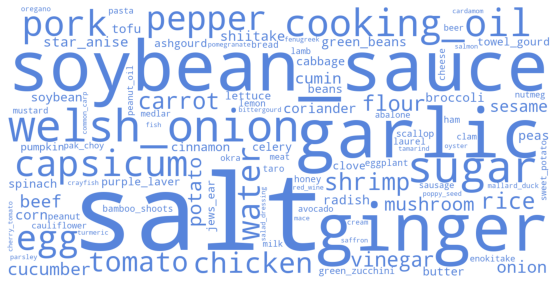

In [102]:
ingredient_wordcloud(xcfc0_vector_df,savory_color_func)
plt.savefig('graphs/pdf/xcf_tb_savoury_cloud.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/xcf_tb_savoury_cloud.png',dpi=300,bbox_inches='tight')

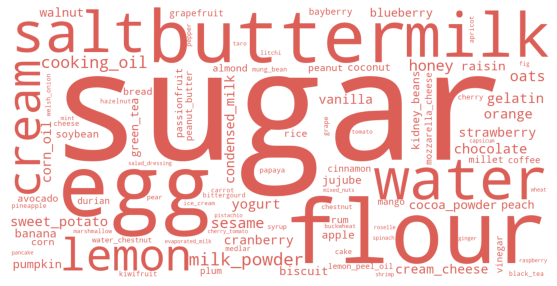

In [103]:
ingredient_wordcloud(xcfc1_vector_df,sweet_color_func)
plt.savefig('graphs/pdf/xcf_tb_sweet_cloud.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/xcf_tb_sweet_cloud.png',dpi=300,bbox_inches='tight')

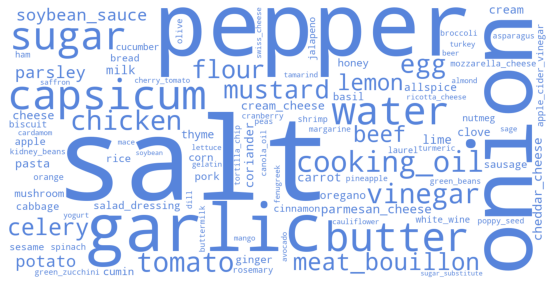

In [104]:
ingredient_wordcloud(arsc0_vector_df,savory_color_func)
plt.savefig('graphs/pdf/ars_tb_savoury_cloud.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/ars_tb_savoury_cloud.png',dpi=300,bbox_inches='tight')

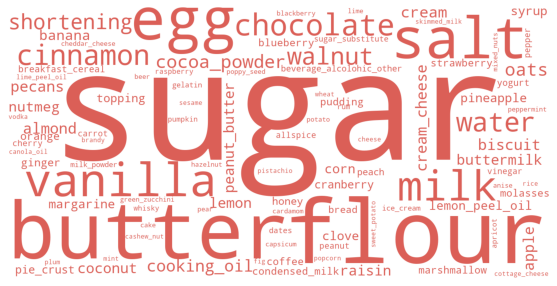

In [105]:
ingredient_wordcloud(arsc1_vector_df,sweet_color_func)
plt.savefig('graphs/pdf/ars_tb_sweet_cloud.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/ars_tb_sweet_cloud.png',dpi=300,bbox_inches='tight')

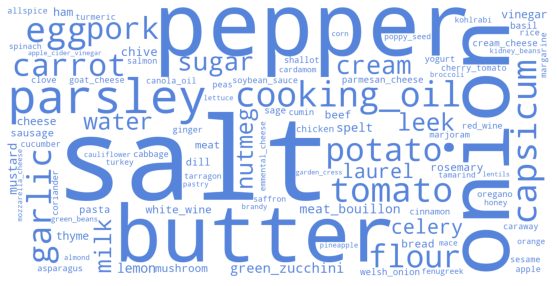

In [109]:
ingredient_wordcloud(kbc0_vector_df,savory_color_func)
plt.savefig('graphs/pdf/kb_tb_savoury_cloud.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/kb_tb_savoury_cloud.png',dpi=300,bbox_inches='tight')

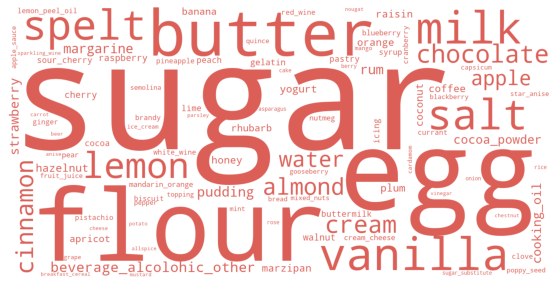

In [108]:
ingredient_wordcloud(kbc1_vector_df,sweet_color_func)
plt.savefig('graphs/pdf/kb_tb_sweet_cloud.pdf',dpi=300,bbox_inches='tight')
plt.savefig('graphs/png/kb_tb_sweet_cloud.png',dpi=300,bbox_inches='tight')

In [ ]:
# adding flavor cluster for the data

In [ ]:
# xiachufang c0: sweet; c1:savory
# allrecipes c0: savory; c1:sweet
# kochbar c0: sweet; c1: savory

In [80]:
xcf_data['flavor_cluster']='savory'
ars_data['flavor_cluster']='savory'
kb_data['flavor_cluster']='savory'

xcf_data['flavor_cluster'][xcf_data['cluster']==1]='sweet'
ars_data['flavor_cluster'][ars_data['cluster']==1]='sweet'
kb_data['flavor_cluster'][kb_data['cluster']==1]='sweet'

In [81]:
xcf_data.head()

,recipe_id,flavordb_ingr,n2v_features,cluster,flavor_cluster
0,100000175,"[rice, salt, cabbage, oats, pepper]","[0.12998615, 0.116523266, -0.12934923, -0.1582...",0,savory
1,100000387,"[salt, broccoli, cooking_oil, pork]","[0.045320638, 0.108172126, -0.038546618, -0.17...",0,savory
2,100000424,"[tomato, soybean_sauce, garlic, salt, cabbage,...","[0.0671796, 0.17074816, -0.070094116, -0.07578...",0,savory
3,100000444,"[shiitake, garlic, salt, cabbage, soybean_sauc...","[0.08900865, 0.0965947, -0.06276641, -0.123147...",0,savory
4,100000562,"[durian, water]","[-0.010832663, -0.25349423, 0.12803248, -0.082...",1,sweet


In [82]:
ars_data.head()

,recipe_id,flavordb_ingr,n2v_features,cluster,flavor_cluster
0,152,"[butter, buttermilk, cooking_oil, egg, flour, ...","[0.11621567, 0.08857763, -0.054273322, -0.1196...",1,sweet
1,198,"[biscuit, butter, codfish, lemon, onion, parsl...","[0.13179116, -0.0033423267, -0.15062986, -0.06...",0,savory
2,313,"[apple, butter, capsicum, cheddar_cheese, egg,...","[0.07221363, 0.11513465, -0.12977144, -0.13726...",1,sweet
3,382,"[beef, carrot, celery, garlic, kale, kidney_be...","[0.08575482, 0.17138842, -0.13551678, -0.14606...",0,savory
4,596,"[biscuit, chocolate, cream_cheese, egg, sugar,...","[0.18244456, -0.055677306, -0.0503502, -0.1237...",1,sweet


In [83]:
kb_data.head()

,recipe_id,flavordb_ingr,n2v_features,cluster,flavor_cluster
0,731,"[asparagus, butter, capsicum, chive, cooking_o...","[0.14468089, 0.10974136, -0.029073082, -0.0439...",0,savory
1,964,"[cocoa_powder, cream, egg, red_wine, sugar]","[0.09935913, 0.010888529, 0.08955122, -0.18694...",1,sweet
2,1182,"[butter, egg, flour, milk, salt, spelt, sugar]","[0.056781262, 0.09734555, 0.07499134, -0.03585...",1,sweet
3,1603,"[chive, onion, parsley, rosemary, water]","[0.28621262, 0.052477974, -0.20165841, -0.0265...",0,savory
4,1680,"[butter, egg, gelatin, lemon, milk, pudding, s...","[0.030184051, -0.018436838, 0.026986, -0.06295...",1,sweet


In [ ]:
# merge app class with the data

In [84]:
xcf_data=pd.merge(xcf_data,xcf_app,on='recipe_id')
ars_data=pd.merge(ars_data,ars_app,on='recipe_id')
kb_data=pd.merge(kb_data,kb_app,on='recipe_id')

In [85]:
xcf_data.head()

,recipe_id,flavordb_ingr,n2v_features,cluster,flavor_cluster,class
0,100000175,"[rice, salt, cabbage, oats, pepper]","[0.12998615, 0.116523266, -0.12934923, -0.1582...",0,savory,1
1,100000387,"[salt, broccoli, cooking_oil, pork]","[0.045320638, 0.108172126, -0.038546618, -0.17...",0,savory,1
2,100000424,"[tomato, soybean_sauce, garlic, salt, cabbage,...","[0.0671796, 0.17074816, -0.070094116, -0.07578...",0,savory,1
3,100000444,"[shiitake, garlic, salt, cabbage, soybean_sauc...","[0.08900865, 0.0965947, -0.06276641, -0.123147...",0,savory,1
4,100000562,"[durian, water]","[-0.010832663, -0.25349423, 0.12803248, -0.082...",1,sweet,1


In [86]:
ars_data.head()

,recipe_id,flavordb_ingr,n2v_features,cluster,flavor_cluster,class
0,152,"[butter, buttermilk, cooking_oil, egg, flour, ...","[0.11621567, 0.08857763, -0.054273322, -0.1196...",1,sweet,0
1,198,"[biscuit, butter, codfish, lemon, onion, parsl...","[0.13179116, -0.0033423267, -0.15062986, -0.06...",0,savory,0
2,313,"[apple, butter, capsicum, cheddar_cheese, egg,...","[0.07221363, 0.11513465, -0.12977144, -0.13726...",1,sweet,0
3,382,"[beef, carrot, celery, garlic, kale, kidney_be...","[0.08575482, 0.17138842, -0.13551678, -0.14606...",0,savory,0
4,596,"[biscuit, chocolate, cream_cheese, egg, sugar,...","[0.18244456, -0.055677306, -0.0503502, -0.1237...",1,sweet,0


In [87]:
kb_data.head()

,recipe_id,flavordb_ingr,n2v_features,cluster,flavor_cluster,class
0,731,"[asparagus, butter, capsicum, chive, cooking_o...","[0.14468089, 0.10974136, -0.029073082, -0.0439...",0,savory,0
1,964,"[cocoa_powder, cream, egg, red_wine, sugar]","[0.09935913, 0.010888529, 0.08955122, -0.18694...",1,sweet,0
2,1182,"[butter, egg, flour, milk, salt, spelt, sugar]","[0.056781262, 0.09734555, 0.07499134, -0.03585...",1,sweet,0
3,1603,"[chive, onion, parsley, rosemary, water]","[0.28621262, 0.052477974, -0.20165841, -0.0265...",0,savory,0
4,1680,"[butter, egg, gelatin, lemon, milk, pudding, s...","[0.030184051, -0.018436838, 0.026986, -0.06295...",1,sweet,0


In [99]:
xcf_data.to_pickle('datasets/(07.10)xcf_n2v_flavorcluster.pkl')
ars_data.to_pickle('datasets/(07.10)ars_n2v_flavorcluster.pkl')
kb_data.to_pickle('datasets/(07.10)kb_n2v_flavorcluster.pkl')

In [ ]:
# check the savory appreciation level

In [15]:
# delete the column cluster in order to avoid misunderstanding

In [21]:
xcf_data.to_pickle('datasets/(30.05)xcf_n2v_flavorcluster.pkl')
ars_data.to_pickle('datasets/(30.05)ars_n2v_flavorcluster.pkl')
kb_data.to_pickle('datasets/(30.05)kb_n2v_flavorcluster.pkl')

In [88]:
xcf_data.drop('cluster',axis=1,inplace=True)
ars_data.drop('cluster',axis=1,inplace=True)
kb_data.drop('cluster',axis=1,inplace=True)

In [89]:
xcf_data=pd.read_pickle('datasets/(30.05)xcf_n2v_flavorcluster.pkl')
ars_data=pd.read_pickle('datasets/(30.05)ars_n2v_flavorcluster.pkl')
kb_data=pd.read_pickle('datasets/(30.05)kb_n2v_flavorcluster.pkl')

In [90]:
ars_data.head()

,recipe_id,flavordb_ingr,n2v_features,flavor_cluster,class
0,152,"[butter, buttermilk, cooking_oil, egg, flour, ...","[0.11621567, 0.08857763, -0.054273322, -0.1196...",sweet,0
1,198,"[biscuit, butter, codfish, lemon, onion, parsl...","[0.13179116, -0.0033423267, -0.15062986, -0.06...",savory,0
2,313,"[apple, butter, capsicum, cheddar_cheese, egg,...","[0.07221363, 0.11513465, -0.12977144, -0.13726...",sweet,0
3,382,"[beef, carrot, celery, garlic, kale, kidney_be...","[0.08575482, 0.17138842, -0.13551678, -0.14606...",savory,0
4,596,"[biscuit, chocolate, cream_cheese, egg, sugar,...","[0.18244456, -0.055677306, -0.0503502, -0.1237...",sweet,0


In [91]:
xcf_flavor_app=xcf_data.groupby(['flavor_cluster','class']).size().reset_index(name='count')
ars_flavor_app=ars_data.groupby(['flavor_cluster','class']).size().reset_index(name='count')
kb_flavor_app=kb_data.groupby(['flavor_cluster','class']).size().reset_index(name='count')

In [92]:
xcf_flavor_app

,flavor_cluster,class,count
0,savory,0,496
1,savory,1,585
2,sweet,0,543
3,sweet,1,742


In [93]:
kb_flavor_app

,flavor_cluster,class,count
0,savory,0,477
1,savory,1,562
2,sweet,0,459
3,sweet,1,366


In [94]:
xcf_flavor_app['prop']=xcf_flavor_app.groupby('class')['count'].apply(lambda x:x/x.sum())

In [95]:
ars_flavor_app['prop']=ars_flavor_app.groupby('class')['count'].apply(lambda x:x/x.sum())

In [96]:
kb_flavor_app['prop']=kb_flavor_app.groupby('class')['count'].apply(lambda x:x/x.sum())

In [97]:
xcf_flavor_app

,flavor_cluster,class,count,prop
0,savory,0,496,0.477382
1,savory,1,585,0.440844
2,sweet,0,543,0.522618
3,sweet,1,742,0.559156


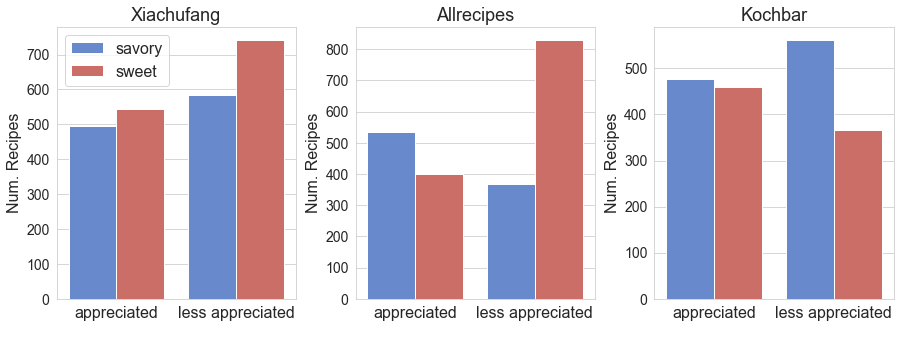

In [94]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,3,figsize=(15,5))
mypalette=["#5784db","#db5f57"]
plt.subplots_adjust(wspace=0.25)

ax1=plt.subplot(131)
ax1=sns.barplot(x='class',y='count',hue='flavor_cluster',data=xcf_flavor_app,palette=mypalette)
ax1.set_xlabel(' ')
ax1.set_ylabel('Num. Recipes',fontsize=16)
ax1.set_xticklabels(['appreciated','less appreciated'],fontsize=16)
ax1.tick_params(axis='y',which='major',labelsize=14)
ax1.legend(fontsize=16)
ax1.set_title('Xiachufang',fontsize=18)

ax2=plt.subplot(132)
ax2=sns.barplot(x='class',y='count',hue='flavor_cluster',data=ars_flavor_app,palette=mypalette)
ax2.set_xlabel(' ')
ax2.set_ylabel('Num. Recipes',fontsize=16)
ax2.set_xticklabels(['appreciated','less appreciated'],fontsize=16)
ax2.tick_params(axis='y',which='major',labelsize=14)
ax2.get_legend().remove()
ax2.set_title('Allrecipes',fontsize=18)

ax3=plt.subplot(133)
ax3=sns.barplot(x='class',y='count',hue='flavor_cluster',data=kb_flavor_app,palette=mypalette)
ax3.set_xlabel(' ')
ax3.set_ylabel('Num. Recipes',fontsize=16)
ax3.set_xticklabels(['appreciated','less appreciated'],fontsize=16)
ax3.tick_params(axis='y',which='major',labelsize=14)
ax3.get_legend().remove()
ax3.set_title('Kochbar',fontsize=18)

# plt.savefig('graphs/pdf/allorign_tb_flavors_counts.pdf',dpi=300,bbox_inches='tight')
# plt.savefig('graphs/png/allorign_tb_flavors_counts.png',dpi=300,bbox_inches='tight')

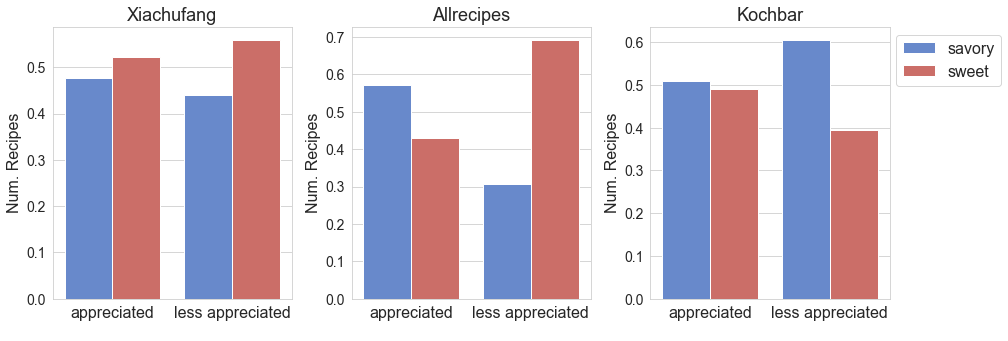

In [33]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,3,figsize=(15,5))
mypalette=["#5784db","#db5f57"]
plt.subplots_adjust(wspace=0.25)

ax1=plt.subplot(131)
ax1=sns.barplot(x='class',y='prop',hue='flavor_cluster',data=xcf_flavor_app,palette=mypalette)
ax1.set_xlabel(' ')
ax1.set_ylabel('Num. Recipes',fontsize=16)
ax1.set_xticklabels(['appreciated','less appreciated'],fontsize=16)
ax1.tick_params(axis='y',which='major',labelsize=14)
ax1.get_legend().remove()
ax1.set_title('Xiachufang',fontsize=18)

ax2=plt.subplot(132)
ax2=sns.barplot(x='class',y='prop',hue='flavor_cluster',data=ars_flavor_app,palette=mypalette)
ax2.set_xlabel(' ')
ax2.set_ylabel('Num. Recipes',fontsize=16)
ax2.set_xticklabels(['appreciated','less appreciated'],fontsize=16)
ax2.tick_params(axis='y',which='major',labelsize=14)
ax2.get_legend().remove()
ax2.set_title('Allrecipes',fontsize=18)

ax3=plt.subplot(133)
ax3=sns.barplot(x='class',y='prop',hue='flavor_cluster',data=kb_flavor_app,palette=mypalette)
ax3.set_xlabel(' ')
ax3.set_ylabel('Num. Recipes',fontsize=16)
ax3.set_xticklabels(['appreciated','less appreciated'],fontsize=16)
ax3.tick_params(axis='y',which='major',labelsize=14)
ax3.get_legend().remove()
ax3.set_title('Kochbar',fontsize=18)
ax3.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.5,1))

#plt.savefig('graphs/pdf/allorign_tb_flavors_prop.pdf',dpi=300,bbox_inches='tight')
#plt.savefig('graphs/png/allorign_tb_flavors_prop.png',dpi=300,bbox_inches='tight')

In [ ]:
# convert pandas for suiting the visualization

In [98]:
def convert_df(df):
    df['class'][df['class']==0]='appreciated'
    df['class'][df['class']==1]='less appreciated'
    df=df.pivot(index='class',columns='flavor_cluster',values='prop')
    return df

In [99]:
xcf_flavor_app_vis=convert_df(xcf_flavor_app)
ars_flavor_app_vis=convert_df(ars_flavor_app)
kb_flavor_app_vis=convert_df(kb_flavor_app)

In [100]:
xcf_flavor_app_vis

flavor_cluster,savory,sweet
class,,
appreciated,0.477382,0.522618
less appreciated,0.440844,0.559156


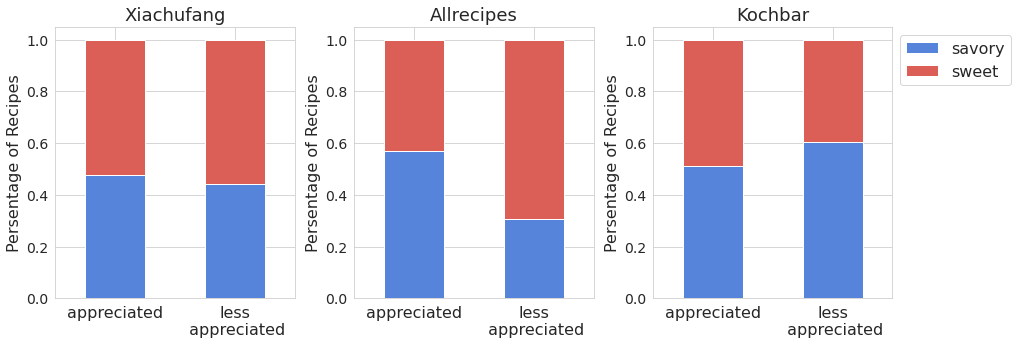

In [101]:
sns.set_style('whitegrid')
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
mypalette=["#5784db","#db5f57"]
plt.subplots_adjust(wspace=0.25)

ax1=xcf_flavor_app_vis.plot(kind='bar',stacked=True,color=mypalette,ax=axes[0])
ax2=ars_flavor_app_vis.plot(kind='bar',stacked=True,color=mypalette,ax=axes[1])
ax3=kb_flavor_app_vis.plot(kind='bar',stacked=True,color=mypalette,ax=axes[2])

for ax in axes:
    ax.set_xlabel(' ')
    ax.set_ylabel('Persentage of Recipes',fontsize=16)
    ax.tick_params(axis='y',which='major',labelsize=14)
    ax.set_xticklabels(['appreciated','less\n appreciated'],fontsize=16,rotation=360)
    ax.get_legend().remove()
    
ax1.set_title('Xiachufang',fontsize=18)
ax2.set_title('Allrecipes',fontsize=18)
ax3.set_title('Kochbar',fontsize=18)

ax3.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.53,1))

#plt.savefig('graphs/pdf/(31.05)allorign_tb_flavors_prop.pdf',dpi=300,bbox_inches='tight')
#plt.savefig('graphs/png/(31.05)allorign_tb_flavors_prop.png',dpi=300,bbox_inches='tight')

In [ ]:
# check the categories of savory and sweet recipes

In [45]:
xcf_data=pd.read_pickle('datasets/(30.05)xcf_n2v_flavorcluster.pkl')
ars_data=pd.read_pickle('datasets/(30.05)ars_n2v_flavorcluster.pkl')
kb_data=pd.read_pickle('datasets/(30.05)kb_n2v_flavorcluster.pkl')

In [46]:
xcf_data.shape

(2366, 5)

In [47]:
xcf_data.head()

,recipe_id,flavordb_ingr,n2v_features,flavor_cluster,class
0,100000175,"[rice, salt, cabbage, oats, pepper]","[0.12998615, 0.116523266, -0.12934923, -0.1582...",savory,1
1,100000387,"[salt, broccoli, cooking_oil, pork]","[0.045320638, 0.108172126, -0.038546618, -0.17...",savory,1
2,100000424,"[tomato, soybean_sauce, garlic, salt, cabbage,...","[0.0671796, 0.17074816, -0.070094116, -0.07578...",savory,1
3,100000444,"[shiitake, garlic, salt, cabbage, soybean_sauc...","[0.08900865, 0.0965947, -0.06276641, -0.123147...",savory,1
4,100000562,"[durian, water]","[-0.010832663, -0.25349423, 0.12803248, -0.082...",sweet,1


In [62]:
xcf_data=xcf_data[['recipe_id','flavordb_ingr','flavor_cluster']]
ars_data=ars_data[['recipe_id','flavordb_ingr','flavor_cluster']]
kb_data=kb_data[['recipe_id','flavordb_ingr','flavor_cluster']]

In [49]:
xcf_tb_cate=pd.read_csv('~/food_preference/cate_datasets/xiachufang_tb_cate.csv',index_col=0)
xcf_tb_cate.shape

(6209, 8)

In [50]:
xcf_tb_cate.head()

,recipe_id,recipe_name,score,cate_g_father,cate_father,cate_name,cate_index,app
0,9650,红枣花生煲鸡爪,6.7,肉类,鸡,鸡爪,1337,1
1,9650,红枣花生煲鸡爪,6.7,热门专题,功效,补血,30051,1
2,9650,红枣花生煲鸡爪,6.7,米面干果腌咸,干果类,枣,2313,1
3,9665,黄瓜炒猪肝,6.5,肉类,猪,猪肝,733,1
4,9672,金沙南瓜,6.9,蔬菜水果,果实类蔬菜,南瓜,455,1


In [51]:
xcf_tb_cate=xcf_tb_cate[['recipe_id','cate_g_father','cate_father']]

In [52]:
xcf_cluster_cate=pd.merge(xcf_data,xcf_tb_cate,on='recipe_id')
xcf_cluster_cate.shape

(2683, 5)

In [53]:
xcf_cluster_cate.drop_duplicates('recipe_id').shape

(1952, 5)

In [54]:
xcf_cluster_cate.head()

,recipe_id,flavordb_ingr,flavor_cluster,cate_g_father,cate_father
0,100000175,"[rice, salt, cabbage, oats, pepper]",savory,蔬菜水果,叶类蔬菜
1,100000175,"[rice, salt, cabbage, oats, pepper]",savory,蔬菜水果,叶类蔬菜
2,100000387,"[salt, broccoli, cooking_oil, pork]",savory,蔬菜水果,叶类蔬菜
3,100000424,"[tomato, soybean_sauce, garlic, salt, cabbage,...",savory,蔬菜水果,叶类蔬菜
4,100000424,"[tomato, soybean_sauce, garlic, salt, cabbage,...",savory,蔬菜水果,叶类蔬菜


In [55]:
xcf_cluster_cate[xcf_cluster_cate['cate_g_father']=='米面干果腌咸']

,recipe_id,flavordb_ingr,flavor_cluster,cate_g_father,cate_father
15,100001688,"[tomato, vinegar, garlic, salt, carrot, cucumb...",savory,米面干果腌咸,米面类
16,100001688,"[tomato, vinegar, garlic, salt, carrot, cucumb...",savory,米面干果腌咸,米面类
19,100002121,"[milk, flour, egg, corn_oil, sugar]",sweet,米面干果腌咸,米面类
20,100002121,"[milk, flour, egg, corn_oil, sugar]",sweet,米面干果腌咸,米面类
29,100007112,"[salt, milk, flour, sugar]",sweet,米面干果腌咸,米面类
...,...,...,...,...,...
2656,94448,"[corn, milk, flour, raisin, sugar]",sweet,米面干果腌咸,米面类
2669,9650,"[jujube, salt, chicken, peanut, ginger]",savory,米面干果腌咸,干果类
2672,98865,"[jujube, flour, butter, egg, water, sugar]",sweet,米面干果腌咸,米面类
2673,98865,"[jujube, flour, butter, egg, water, sugar]",sweet,米面干果腌咸,干果类


In [43]:
xcf_cluster_cate.groupby('flavor_cluster')['cate_g_father'].value_counts()

flavor_cluster  cate_g_father
savory          蔬菜水果             585
                肉类               204
                水产               129
                米面干果腌咸            98
                热门专题              80
                口味特色              76
                蛋奶豆制品             22
                汤粥主食              20
                烘焙甜品饮料            10
sweet           蔬菜水果             445
                米面干果腌咸           411
                蛋奶豆制品            260
                烘焙甜品饮料           174
                热门专题              92
                口味特色              66
                肉类                 6
                水产                 4
                汤粥主食               1
Name: cate_g_father, dtype: int64

In [ ]:
# load allrecipes cate data

In [57]:
ars_cate=pd.read_csv('~/food_preference/cate_datasets/allrecipes_cate.csv',index_col=0)
ars_cate.shape

(156345, 4)

In [60]:
ars_cate=ars_cate[ars_cate['recipe_category_level']==3]
ars_cate.shape

(31194, 4)

In [61]:
ars_cate.head()

,recipe_id,bookmarks_log,recipe_category_level,recipe_category_name
4,100112,5.602119,3,Side Dish
10,100037,4.787492,3,Main Dish
17,100075,6.982863,3,Desserts
22,100055,4.488636,3,Salad
27,100051,4.219508,3,Side Dish


In [63]:
ars_cluster_cate=pd.merge(ars_data,ars_cate,on='recipe_id')
ars_cluster_cate.shape

(1957, 6)

In [64]:
ars_cluster_cate.head()

,recipe_id,flavordb_ingr,flavor_cluster,bookmarks_log,recipe_category_level,recipe_category_name
0,152,"[butter, buttermilk, cooking_oil, egg, flour, ...",sweet,7.532624,3,Breakfast and Brunch
1,198,"[biscuit, butter, codfish, lemon, onion, parsl...",savory,6.522093,3,Main Dish
2,313,"[apple, butter, capsicum, cheddar_cheese, egg,...",sweet,4.488636,3,Appetizers and Snacks
3,382,"[beef, carrot, celery, garlic, kale, kidney_be...",savory,4.736198,3,"Soups, Stews and Chili"
4,596,"[biscuit, chocolate, cream_cheese, egg, sugar,...",sweet,6.645091,3,Trusted Brands: Recipes and Tips


In [65]:
ars_cluster_cate.groupby('flavor_cluster')['recipe_category_name'].value_counts()

flavor_cluster  recipe_category_name            
savory          Main Dish                           229
                Side Dish                           161
                Appetizers and Snacks               114
                Soups, Stews and Chili               96
                Meat and Poultry                     64
                Salad                                63
                Trusted Brands: Recipes and Tips     28
                Desserts                             15
                Drinks                               13
                Breakfast and Brunch                 10
                Bread                                 9
                Everyday Cooking                      9
sweet           Desserts                            742
                Bread                               121
                Side Dish                           109
                Breakfast and Brunch                 64
                Trusted Brands: Recipes and Tips     45

In [66]:
ars_cluster_cate[ars_cluster_cate['recipe_category_name']=='Appetizers and Snacks']

,recipe_id,flavordb_ingr,flavor_cluster,bookmarks_log,recipe_category_level,recipe_category_name
2,313,"[apple, butter, capsicum, cheddar_cheese, egg,...",sweet,4.488636,3,Appetizers and Snacks
14,3551,"[capsicum, cherry_tomato, coriander, garlic, l...",savory,5.703782,3,Appetizers and Snacks
18,6206,"[allspice, celery, chicken, clove, cooking_oil...",savory,6.711740,3,Appetizers and Snacks
19,6224,"[allspice, cheddar_cheese, chicken, cream_chee...",savory,6.011267,3,Appetizers and Snacks
34,10726,"[allspice, celery, cream_cheese, garlic, olive...",savory,5.961005,3,Appetizers and Snacks
...,...,...,...,...,...,...
1880,223774,"[beetroot, capsicum, salt, vinegar]",savory,3.496508,3,Appetizers and Snacks
1923,234086,"[basil, bread, butter, garlic, salt]",savory,0.000000,3,Appetizers and Snacks
1939,237888,"[crab, jalapeno, peanut]",sweet,5.187386,3,Appetizers and Snacks
1948,239634,"[butter, chicken, mustard, soybean_sauce, suga...",savory,5.799093,3,Appetizers and Snacks
